In [1]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
import pypfilt
import h5py
import scipy


def kalmanfilter_randomwalk(obs, sigma_w=10, sigma_r=10):
    kalman = KalmanFilter(obs.shape[1], 1)
    kalman.x = np.zeros((kalman.dim_x, 1))
    kalman.P = np.eye(kalman.dim_x) * 1 ** 2
    kalman.Q = (np.eye(kalman.dim_x) * 0.2 ** 2)
    kalman.R = (np.eye(kalman.dim_z) * 0.1 ** 2)
    kalman.F = np.eye(kalman.dim_x)

    kalman.predict()

    states = [kalman.x[:, 0]]

    for r in obs:
        # prediction
        kalman.update(r, H=np.eye(kalman.dim_x))
        kalman.predict()
        states.append(kalman.x[:, 0])

    states = np.array(states)

    return states


class RandomWalk(pypfilt.Model):
    def init(self, params, vec):
        rnd = params['resample']['rnd']
        size = vec[..., 0].shape
        vec[..., 0] = params['prior']['states'](rnd, size)

    def state_size(self):
        return 1

    def priors(self, params):
        return {
            'states': lambda r, size=None: np.zeros(size)
        }

    def update(self, params, t, dt, is_fs, prev, curr):
        curr[:] = [np.random.normal(pre, params['obs']['sigma_w'])
                   for pre in prev]

    def describe(self):
        return [
            ('states', False, -1e5, 1e5),
        ]


def log_llhd(params, obs_list, curr, prev_dict, weights):
    log_llhd = np.zeros(curr.shape[:-1])
    for o in obs_list:
        if o['unit'] == 'states':
            states_dist = scipy.stats.norm(loc=curr[..., 0],
                                           scale=params['obs']['sigma_r'])
            log_llhd += states_dist.pdf(o['value'])
        else:
            raise ValueError('invalid observation')
    return log_llhd


def make_randomwalk_params(px_count, ret=0.25, sigma_r=1, sigma_w=10):
    model = RandomWalk()
    time_scale = pypfilt.Scalar()
    params = pypfilt.default_params(model, time_scale, px_count=px_count)
    params['steps_per_unit'] = 1
    params['log_llhd_fn'] = log_llhd
    params['obs'] = {'sigma_r': sigma_r, 'ret': ret, 'sigma_w': sigma_w}
    params['resample']['prng_seed'] = 0
    params['resample']['threshold'] = 0.5
    params['out_dir'] = '.'
    params['tmp_dir'] = '.'
    return params


def bootstrap_forecast_randomwalk(obs, sigma_w=10, sigma_r=1, t0=0.0, t1=100.0):
    fs_times = list(range(1, len(obs)))
    fs_times = [float(time) for time in fs_times]
    params = make_randomwalk_params(px_count=1000, sigma_r=sigma_r, sigma_w=sigma_w)

    summary = pypfilt.summary.HDF5(params, obs, first_day=True)
    summary.add_tables(
        pypfilt.summary.ModelCIs(probs=[0], name=u'model_cints'),
        pypfilt.summary.Obs())
    pypfilt.forecast(params,
                     t0,
                     t1,
                     [obs],
                     fs_times,
                     summary,
                     'output')


if __name__ == "__main__":

    X = np.linspace(0, 20, 100)
    noisy_Y = np.array([np.random.normal(np.sin(x), 0.1) for x in X]).reshape(100, 1)
    real_Y = np.sin(X)

    obs = [{'date': i,
            'value': ret,
            'unit': 'states',
            'period': 1,
            'source': 'Some system'}
           for i, ret in enumerate(noisy_Y)]

    bootstrap_forecast_randomwalk(obs, sigma_w=0.2, sigma_r=0.1)
    states = kalmanfilter_randomwalk(noisy_Y, sigma_w=0.2, sigma_r=0.1)

    data = h5py.File('output', 'r')
    cints = data['data']['model_cints']
    convs = pypfilt.summary.default_converters(pypfilt.Scalar())
    cints = pypfilt.summary.convert_cols(cints, convs)
    state_cints = cints[cints['name'] == b'states']
    fs_mask = state_cints['fs_date'] < max(state_cints['date'])
    state_cints = state_cints[fs_mask]
    data.close()
    state_cints[:100]
    real_states = []
    for state in state_cints:
        if state[0] == state[1]:
            real_states.append(state[3])
    
    plt.plot(real_states, color='blue', label='pypfilt result')
    plt.plot(states[2:], color='red', label='kalman result')
    plt.plot(real_Y[1:], color='black', label='real results')
    plt.show()


<Figure size 640x480 with 1 Axes>

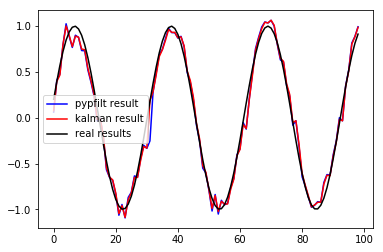

In [6]:
plt.plot(real_states, color='blue', label='pypfilt result')
plt.plot(states[2:], color='red', label='kalman result')
plt.plot(real_Y[1:], color='black', label='real results')
plt.legend()
plt.show()